In [227]:
# https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DSPR-2.0+14JULY2021/courseware/64fb8f8af1424a7788ba0e45453617fc/fe7f54b798d642c9990b9f43ccd7b492/1?activate_block_id=block-v1%3ASkillFactory%2BDSPR-2.0%2B14JULY2021%2Btype%40html%2Bblock%403bddec1d246549348a1e5440710424d4
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 40) # выводить больше столбцов
pd.set_option('display.max_rows', 40)   # выводить больше строк

# plt.style.use('default')    # корректный вывод графиков в темной теме Matplotlib
# fig.show(renderer='notebook') #включение анимации
#!/usr/bin/env python

import io
import zipfile
import requests  

link = "https://lms.skillfactory.ru/assets/courseware/v1/f9f05ba6ecb36996a8ec5c6e89cd2a75/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_data.zip" # put link here

# unzip with link
r = requests.get(link) # link
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
  archive.extractall('data')

# # unzip file on the disk
# with zipfile.ZipFile('data/wine_cleared.zip', 'r') as archive:
#     archive.extractall('data')

# download file 
# f=open(r'data\pizzas.csv',"wb") #открываем файл для записи, в режиме wb
# ufr = requests.get(link) #делаем запрос
# f.write(ufr.content) #записываем содержимое в файл; как видите - content запроса
# f.close()


In [228]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [229]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [230]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [231]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [232]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
daily_data.head()


,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


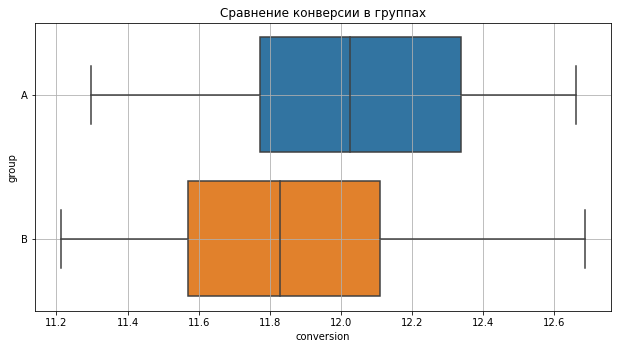

In [233]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

In [234]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


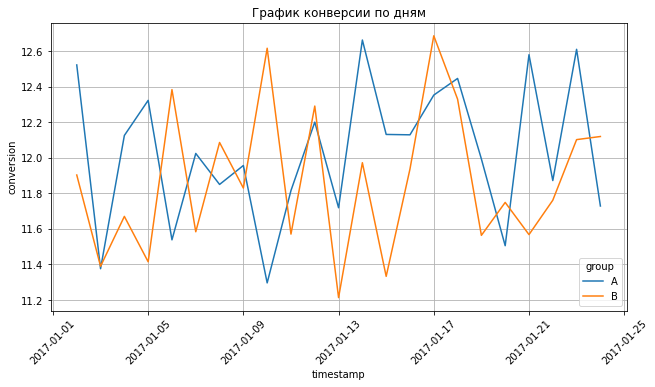

In [235]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [236]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\Denis.kozarenko\AppData\Local\Temp\ipykernel_27024\906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [237]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


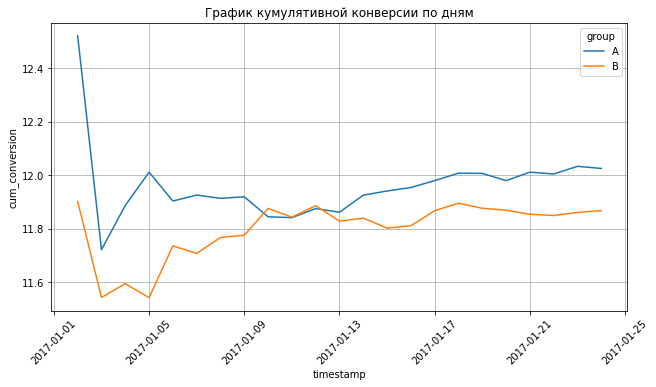

In [238]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [239]:
from statsmodels.stats.proportion import proportions_ztest
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [240]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Итак, мы получили . Оно больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 


На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
попытаться усовершенствовать модель и провести тестирование снова;
использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.
Примечание. Важно отметить, что тест для пропорций можно применять не только к конверсии. Например, так же можно оценивать долю больных людей, долю просроченных кредитов и так далее.

✏️ Заметим, что, если повысить уровень значимости до , то есть «ослабить» требование по точности, можно получить уровень конверсии в группе А, всё-таки превышающий конверсию в группе B. Выполните предыдущий код, чтобы убедиться в этом. Предварительно задайте значение переменной . 

Результат должен быть следующим:

# p-value:  0.1
# Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
# Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B
Таким образом, при уровне значимости  гипотеза о равенстве конверсий всё же отвергается. В таком случае считается, что первая версия рекомендаций лучше, чем вторая версия. 

Какой уровень значимости выбрать?

Стараются придерживаться уровней значимости  или . Помним, что больший уровень значимости подразумевает больший риск совершить ошибку I рода (отклонить верную нулевую гипотезу).
Вы сами определяете уровень значимости в зависимости от вашей гипотезы и того, сколько будет стоить вам ошибка I рода.
Как правило, если возникают спорные ситуации, то склоняются в пользу уже существующего варианта А, так как он не требует временных и денежных затрат на внедрение.
В нашем примере варианты А и B оказались равными по признаку конверсии при уровне значимости , однако при уровне значимости  вариант А оказывается более эффективным.
Так или иначе, немедленное внедрение варианта B — определённо не лучшая идея. Либо его необходимо доработать и провести тестирование заново, либо стоит отказаться от него вовсе.

In [241]:
import io
import zipfile
import requests  

link1 = "https://lms.skillfactory.ru/assets/courseware/v1/c3bcdf8e84ea8fc45d08fe987299dea2/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_test-redesign_sample_a.zip" # put link here

# unzip with link
r = requests.get(link1) # link
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
  archive.extractall('data')

link2 = "https://lms.skillfactory.ru/assets/courseware/v1/91524f30dbacb1a751a1d4a935b8f7bb/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_test-redesign_sample_b.zip" # put link here

# unzip with link
r = requests.get(link2) # link
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
  archive.extractall('data')

In [242]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')
sample_a.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


In [243]:
ab_data = pd.concat([sample_a , sample_b], ignore_index=True)
ab_data['date'] = pd.to_datetime(ab_data['date'], format='%Y-%m-%d')
ab_data['group'] = ab_data['group'].astype('category')



In [244]:
# Задание 4.6 Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?
mask = ((ab_data["date"] == "2020-11-08") & (ab_data["group"] == "A" ))

# Количество посетителей сайта:
display(f'Количество посетителей сайта: {ab_data[mask]["cid"].count()}')

# Суммарное число транзакций:
display(f'Cуммарное число транзакций: {ab_data[mask]["transactions"].sum()}')

# Общая сумма покупок:
display(f'Общая сумма покупок: {ab_data[mask]["revenue"].sum()}')

'Количество посетителей сайта: 3354'

'Cуммарное число транзакций: 25'

'Общая сумма покупок: 846051'

In [245]:
import numpy as np
# Задание 4.7
# Добавьте в каждую из таблиц кумулятивные метрики:
# кумулятивное количество посетителей сайта;
# кумулятивное суммарное число транзакций;
# кумулятивная общая сумма покупок (кумулятивная выручка).
# Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

# Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите. 

df1 = pd.pivot_table(ab_data, index=["date", "group"], values=["revenue", "transactions"], aggfunc=np.sum).rename(columns = {"revenue":"daily_revenue" , "transactions":"daily_trans"})
df2 = pd.pivot_table(ab_data, index=["date", "group"], values=["cid"], aggfunc=len).rename(columns = {"cid":"daily_users"})
daily_data = pd.concat([df1, df2], axis= 1 )
daily_data["d_conversion"] = daily_data["daily_trans"] / daily_data["daily_users"] * 100
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['daily_users'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_trans'] = daily_data.groupby(['group'])['daily_trans'].cumsum()
# вычисляем кумулятивную сумму совершённых покупок
daily_data['cum_revenue'] = daily_data.groupby(['group'])['daily_revenue'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_trans']/daily_data['cum_users_count'] * 100
# вычисляем кумулятивный средний чек
daily_data['cum_aver_check'] = daily_data['cum_revenue']/daily_data['cum_trans']
daily_data['d_aver_check'] = daily_data['daily_revenue']/daily_data['daily_trans']
daily_data


daily_revenue  daily_trans  daily_users  d_conversion  \
date       group                                                          
2020-11-06 A            1577279           16         2576      0.621118   
           B             996645           19         2499      0.760304   
2020-11-07 A            1721886           23         2704      0.850592   
           B             555499           19         2804      0.677603   
2020-11-08 A             846051           25         3354      0.745379   
           B            3044842           24         3291      0.729262   
2020-11-09 A             708830           18         3234      0.556586   
           B            1285836           25         3062      0.816460   
2020-11-10 A             826984           29         3022      0.959629   
           B            2414726           30         3072      0.976562   
2020-11-11 A            1209656           19         3218      0.590429   
           B            3555727           22         3208      0.685786   
2020-11-12 A             607839           19         3467      0.548024   
           B             915653           25         3494      0.715512   
2020-11-13 A            1338816           36         3676      0.979325   
           B            1703475           37         3606      1.026068   
2020-11-14 A            2659277           30         3372      0.889680   
           B            2369998           34         3276      1.037851   
2020-11-15 A            1189970           27         3881      0.695697   
           B            1147144           27         3919      0.688951   
2020-11-16 A            4213774           30         4766      0.629459   
           B            1553700           27         4883      0.552939   
2020-11-17 A            1779293           21         4309      0.487352   
           B            1069200           26         4313      0.602829   
2020-11-18 A             939301           20         3718      0.537924   
           B            2100459           18         3710      0.485175   
2020-11-19 A            2166766           26         3234      0.803958   
           B            2770174           29         3171      0.914538   
2020-11-20 A            1119974           25         3168      0.789141   
           B            1019850           15         3075      0.487805   
2020-11-21 A             939670           18         3116      0.577664   
           B            2586267           22         3129      0.703100   
2020-11-22 A            1205426           33         3298      1.000606   
           B            1779841           34         3378      1.006513   
2020-11-23 A             858274           26         3458      0.751880   
           B            1585306           30         3493      0.858861   

                  cum_users_count  cum_trans  cum_revenue  cum_conversion  \
date       group                                                            
2020-11-06 A                 2576         16      1577279        0.621118   
           B                 2499         19       996645        0.760304   
2020-11-07 A                 5280         39      3299165        0.738636   
           B                 5303         38      1552144        0.716576   
2020-11-08 A                 8634         64      4145216        0.741256   
           B                 8594         62      4596986        0.721434   
2020-11-09 A                11868         82      4854046        0.690934   
           B                11656         87      5882822        0.746397   
2020-11-10 A                14890        111      5681030        0.745467   
           B                14728        117      8297548        0.794405   
2020-11-11 A                18108        130      6890686        0.717915   
           B                17936        139     11853275        0.774978   
2020-11-12 A                21575        149      7498525        0.690614   
           B

In [246]:
sample_a_agg = sample_a.groupby('date').agg({'cid': 'count', 'transactions': 'sum', 'revenue': 'sum'})
sample_b_agg = sample_b.groupby('date').agg({'cid': 'count', 'transactions': 'sum', 'revenue': 'sum'})

print(sample_a_agg['transactions'].cumsum() / sample_a_agg['cid'].cumsum() * 100 )

print(sample_b_agg['transactions'].cumsum() / sample_b_agg['cid'].cumsum() * 100)

date
2020-11-06    0.621118
2020-11-07    0.738636
2020-11-08    0.741256
2020-11-09    0.690934
2020-11-10    0.745467
2020-11-11    0.717915
2020-11-12    0.690614
2020-11-13    0.732644
2020-11-14    0.751144
2020-11-15    0.744524
2020-11-16    0.729809
2020-11-17    0.704683
2020-11-18    0.690995
2020-11-19    0.698523
2020-11-20    0.704076
2020-11-21    0.696890
2020-11-22    0.714126
2020-11-23    0.716246
dtype: float64
date
2020-11-06    0.760304
2020-11-07    0.716576
2020-11-08    0.721434
2020-11-09    0.746397
2020-11-10    0.794405
2020-11-11    0.774978
2020-11-12    0.765282
2020-11-13    0.802844
2020-11-14    0.830037
2020-11-15    0.812882
2020-11-16    0.778682
2020-11-17    0.760374
2020-11-18    0.737754
2020-11-19    0.749358
2020-11-20    0.733706
2020-11-21    0.731949
2020-11-22    0.747970
2020-11-23    0.754281
dtype: float64


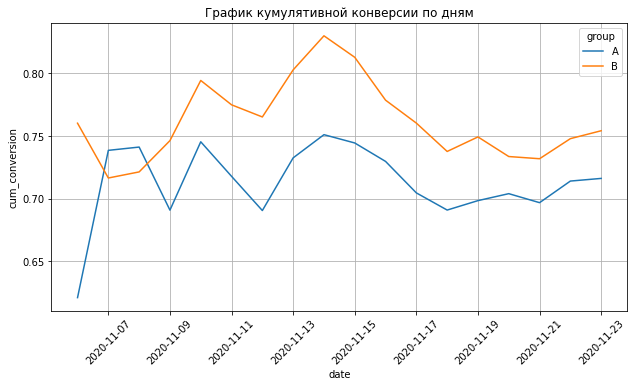

In [247]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

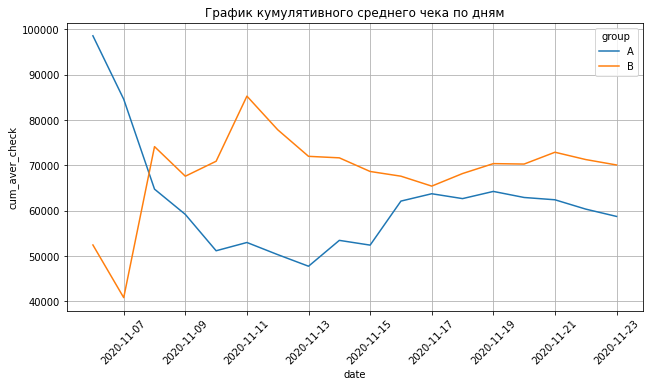

In [248]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_aver_check', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

# 5. Анализ результатов A/B-тестирования: статистические тесты

In [249]:
import io
import zipfile
import requests  

link1 = "https://lms.skillfactory.ru/assets/courseware/v1/fa6ff6fcf8330b73c486bd328d47b632/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/time_data.zip" # put link here

# unzip with link
r = requests.get(link1) # link
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
  archive.extractall('data')

In [250]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


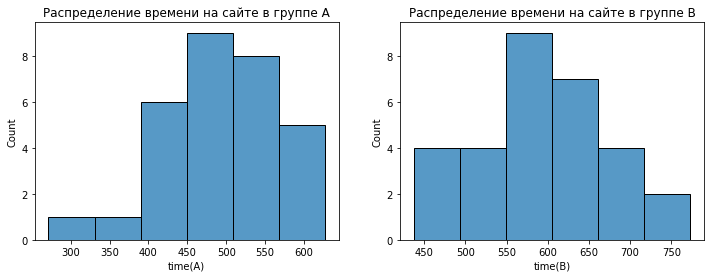

In [251]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [252]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [253]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


In [254]:
from statsmodels.stats.proportion import proportions_ztest
trans_piv= ab_data.groupby('group')['transactions'].agg(
    ['sum', 'count']
)
display(trans_piv)

,sum,count
group,,
A,441,61571
B,463,61383


In [255]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А ниже, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=trans_piv['sum'], #число "успехов"
    nobs=trans_piv['count'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


In [274]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
# daily_data.filter(regex='A', axis=0)['d_aver_check']
shapiro_result_a = shapiro(daily_data.filter(regex='A', axis=0)['d_aver_check'])
shapiro_result_b = shapiro(daily_data.filter(regex='B', axis=0)['d_aver_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [279]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
alpha = 0.1
H0 = 'Средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
# daily_data.filter(regex='A', axis=0)['d_aver_check']
_, mannwhitneyu_result = mannwhitneyu(daily_data.filter(regex='A', axis=0)['d_aver_check'], 
                                   daily_data.filter(regex='A', axis=0)['d_aver_check'], 
                                   alternative='less')

print(f'mannwhitneyu_result = {round(mannwhitneyu_result, 2)}')

# сравниваем mannwhitneyu_result 
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

mannwhitneyu_result = 0.51
Отвергаем нулевую гипотезу. Средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B.


# 6. Анализ результатов A/B-тестирования: доверительные интервалы

## задачa

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

In [281]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости


from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое !!! norm.ppf возвращает отрицательный модуль!!!

eps = z_crit * sigma/(n ** 0.5) #погрешность

lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница

confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
# Доверительный интервал: (12180, 20020)


Доверительный интервал: (12180, 20020)


In [283]:
# Задание 6.5 
# Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. 
# Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. 
# Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.



n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости


from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое !!! norm.ppf возвращает отрицательный модуль!!!

eps = z_crit * sigma/(n ** 0.5) #погрешность

lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница

confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
print(f'z-crit: {round(z_crit,2)} \n Доверительный интервал: {confidence_interval}') # выводим результат
# Доверительный интервал: (12180, 20020)

z-crit: 1.64 
 Доверительный интервал: (11.86, 12.84)


# ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

In [284]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
# Доверительный интервал: (1778, 2222)


Доверительный интервал: (1778, 2222)


Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

Выборка должна быть случайной.
Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

## Задание 6.6
Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [285]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 

Доверительный интервал: (3146, 3934)


# ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [286]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [289]:
from scipy.stats import t , norm

#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % </br>
конверсия группы А лежит в интервале от 11.86 % до 12.19 %, </br>
а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.</br>

✏️ Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [290]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %.

## Задание 6.9
3 points possible (graded)
Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

In [2]:
from scipy.stats import t , norm

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
 
n=189
x_p=132/n

conf_interval_a = proportions_conf_interval(
n=189, # размер выборки
x_p=132/n, # выборочная пропорция
gamma = 0.9
)
print(f'Выборочная пропорция: {round(x_p, 3)} Доверительный интервал для конверсии группы А: {conf_interval_a}')


Выборочная пропорция: 0.698 Доверительный интервал для конверсии группы А: (64.35, 75.33)


Задание 6.10
3 points possible (graded)
Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

Группа &emsp;&emsp;&emsp;&emsp;&emsp; Число добавленных в корзину товаров &emsp;&emsp;&emsp;&emsp;&emsp; Размер выборки

А (Персональные скидки) &emsp;&emsp;&emsp;&emsp;&emsp; 45 &emsp;&emsp;&emsp;&emsp;&emsp; 1000

B (Хиты продаж) &emsp;&emsp;&emsp;&emsp;&emsp; 50 &emsp;&emsp;&emsp;&emsp;&emsp; 1000

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [299]:
from scipy.stats import t , norm

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=1000, # размер выборки
x_p=45/n # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=1000, # размер выборки
x_p=50/n # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [1000, 1000]
# выборочная пропорция групп A и B
xp = [45/1000, 50/1000]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (21.17, 26.45)
Доверительный интервал для конверсии группы B: (23.72, 29.19)
Доверительный интервал для разности конверсий: (-1.36, 2.36)
